In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_recall_fscore_support,
    classification_report, ConfusionMatrixDisplay
)

encoded_df = pd.read_csv('../../prepare_dataset/data/dataset_new_cat.csv')

In [23]:
encoded_data = encoded_df.copy()

y = encoded_data['density']
y = LabelEncoder().fit_transform(y)

features = encoded_data.columns.drop('density')
X = encoded_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Training Time: 172.27 seconds

Metrics:
          Accuracy   ROC AUC  Precision    Recall  F1-score
Training  0.951061  0.995295   0.951679  0.951061  0.951139
Testing   0.743529  0.907300   0.751530  0.743529  0.746448

Detailed Classification Report:

Training Set:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       644
           1       0.94      0.94      0.94       594
           2       0.93      0.97      0.95       458

    accuracy                           0.95      1696
   macro avg       0.95      0.95      0.95      1696
weighted avg       0.95      0.95      0.95      1696


Test Set:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       177
           1       0.64      0.69      0.66       143
           2       0.69      0.71   

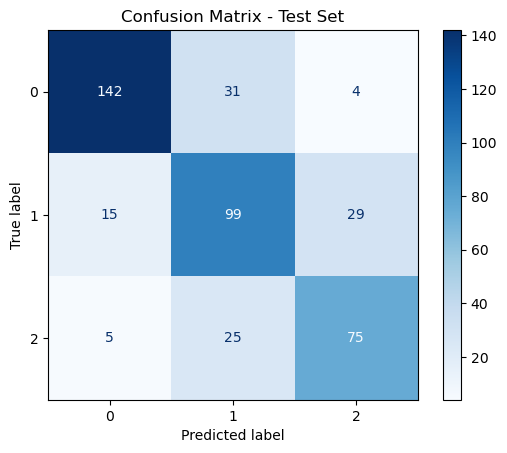

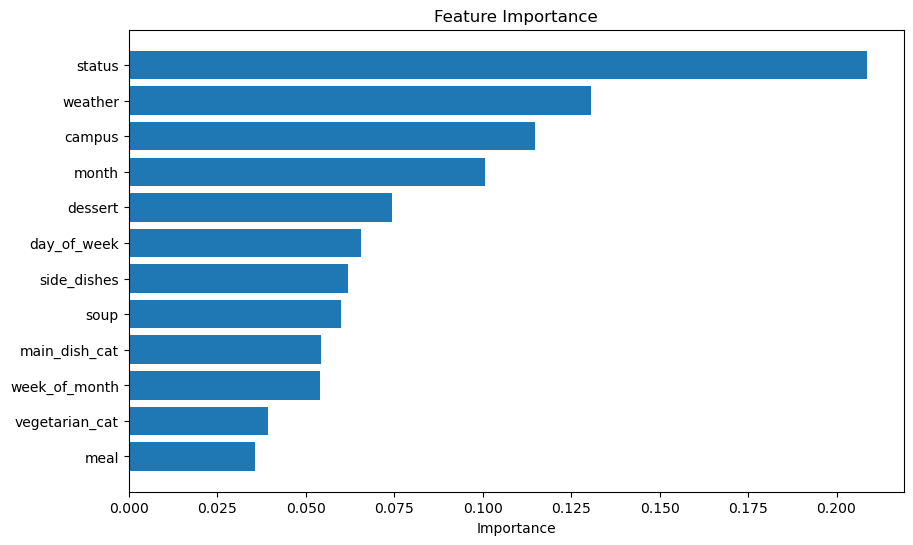


Feature Importance:
           Feature  Importance
11          status    0.208550
1          weather    0.130599
0           campus    0.114779
8            month    0.100717
5          dessert    0.074399
6      day_of_week    0.065679
4      side_dishes    0.061900
3             soup    0.059839
10   main_dish_cat    0.054460
7    week_of_month    0.053939
9   vegetarian_cat    0.039470
2             meal    0.035668

Class Distribution:
Training set:
0    0.379717
1    0.350236
2    0.270047
Name: proportion, dtype: float64

Test set:
0    0.416471
1    0.336471
2    0.247059
Name: proportion, dtype: float64


In [14]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5)

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_rf = grid_search.best_estimator_

train_pred = best_rf.predict(X_train)
test_pred = best_rf.predict(X_test)
train_prob = best_rf.predict_proba(X_train)
test_prob = best_rf.predict_proba(X_test)

metrics = {
    'Training': {
        'Accuracy': accuracy_score(y_train, train_pred),
        'ROC AUC': roc_auc_score(y_train, train_prob, multi_class='ovr'),
    },
    'Testing': {
        'Accuracy': accuracy_score(y_test, test_pred),
        'ROC AUC': roc_auc_score(y_test, test_prob, multi_class='ovr'),
    }
}

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, train_pred, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, test_pred, average='weighted')

metrics['Training'].update({
    'Precision': train_precision,
    'Recall': train_recall,
    'F1-score': train_f1
})

metrics['Testing'].update({
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-score': test_f1
})

print(f"Best Parameters: {grid_search.best_params_}")
print(f"\nTraining Time: {training_time:.2f} seconds")

metrics_df = pd.DataFrame(metrics).T
print("\nMetrics:")
print(metrics_df)

print("\nDetailed Classification Report:")
print("\nTraining Set:")
print(classification_report(y_train, train_pred))
print("\nTest Set:")
print(classification_report(y_test, test_pred))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

print("\nClass Distribution:")
print("Training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTest set:")
print(pd.Series(y_test).value_counts(normalize=True))


# XGBOOST

In [15]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

print("Starting Grid Search...")
start_time = time.time()
grid_search = GridSearchCV(
    xgb_clf, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

best_model = grid_search.best_estimator_

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

train_prob = best_model.predict_proba(X_train)
test_prob = best_model.predict_proba(X_test)

metrics = {
    'Training': {
        'Accuracy': accuracy_score(y_train, train_pred),
        'ROC AUC': roc_auc_score(y_train, train_prob, multi_class='ovr'),
    },
    'Testing': {
        'Accuracy': accuracy_score(y_test, test_pred),
        'ROC AUC': roc_auc_score(y_test, test_prob, multi_class='ovr'),
    }
}

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, train_pred, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average='weighted')

metrics['Training'].update({
    'Precision': train_precision,
    'Recall': train_recall,
    'F1-score': train_f1
})

metrics['Testing'].update({
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-score': test_f1
})

print("\nXGBoost Classification Results")
print("=" * 50)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {training_time:.2f} seconds")

print("\nTraining Set Metrics:")
for metric, value in metrics['Training'].items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
for metric, value in metrics['Testing'].items():
    print(f"{metric}: {value:.4f}")

print("\nDetailed Classification Report:")
print("\nTraining Set:")
print(classification_report(y_train, train_pred))
print("\nTest Set:")
print(classification_report(y_test, test_pred))

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

print("\nClass Distribution:")
print("Training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTest set:")
print(pd.Series(y_test).value_counts(normalize=True))

Starting Grid Search...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

XGBoost Classification Results
Best Parameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Time: 154.77 seconds

Training Set Metrics:
Accuracy: 1.0000
ROC AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Test Set Metrics:
Accuracy: 0.7929
ROC AUC: 0.9375
Precision: 0.7990
Recall: 0.7929
F1-score: 0.7948

Detailed Classification Report:

Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       594
           2       1.00      1.00      1.00       458

    accuracy                           1.00      1696
   macro avg       1.00      1.00      1.00      1696
weighted avg       1.00      1.00      1.00      1696


Test Set:
              precision    recall  f1-score   support

           0     

# Count as target

In [24]:
encoded_data = encoded_df.copy()

def categorize_by_std(group):
    mean = group.mean()
    std = group.std()
    
    conditions = [
        ((group < (mean - 0.5*std))),  # Low: below -0.5 std
        (((mean - 0.5*std) < group) & (group < (mean + 0.5*std))),  # Medium: between -0.5 and 0.5 std
        (((mean + 0.5*std) < group)),  # High: above 0.5 std
    ]
    choices = ['Low', 'Medium', 'High']
    return np.select(conditions, choices, default='Medium')

# Create target variable from raw counts
y = encoded_data['density']
X = encoded_data[features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

# Perform GridSearchCV with 5-fold cross-validation
print("Starting Grid Search...")
start_time = time.time()
grid_search = GridSearchCV(
    xgb_clf, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Get best model
best_model = grid_search.best_estimator_

# Make predictions
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

# Calculate probabilities for ROC AUC
train_prob = best_model.predict_proba(X_train)
test_prob = best_model.predict_proba(X_test)

# Calculate metrics
metrics = {
    'Training': {
        'Accuracy': accuracy_score(y_train, train_pred),
        'ROC AUC': roc_auc_score(y_train, train_prob, multi_class='ovr'),
    },
    'Testing': {
        'Accuracy': accuracy_score(y_test, test_pred),
        'ROC AUC': roc_auc_score(y_test, test_prob, multi_class='ovr'),
    }
}

# Get precision, recall, and F1 scores
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, train_pred, average='weighted')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average='weighted')

metrics['Training'].update({
    'Precision': train_precision,
    'Recall': train_recall,
    'F1-score': train_f1
})

metrics['Testing'].update({
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-score': test_f1
})

# Print results
print("\nXGBoost Classification Results")
print("=" * 50)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Time: {training_time:.2f} seconds")

print("\nTraining Set Metrics:")
for metric, value in metrics['Training'].items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
for metric, value in metrics['Testing'].items():
    print(f"{metric}: {value:.4f}")

print("\nDetailed Classification Report:")
print("\nTraining Set:")
print(classification_report(y_train, train_pred))
print("\nTest Set:")
print(classification_report(y_test, test_pred))

# Feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Print class distribution
print("\nClass Distribution:")
print("Training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTest set:")
print(pd.Series(y_test).value_counts(normalize=True))

Starting Grid Search...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

XGBoost Classification Results
Best Parameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Training Time: 126.22 seconds

Training Set Metrics:
Accuracy: 1.0000
ROC AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Test Set Metrics:
Accuracy: 0.7929
ROC AUC: 0.9375
Precision: 0.7990
Recall: 0.7929
F1-score: 0.7948

Detailed Classification Report:

Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       594
           2       1.00      1.00      1.00       458

    accuracy                           1.00      1696
   macro avg       1.00      1.00      1.00      1696
weighted avg       1.00      1.00      1.00      1696


Test Set:
              precision    recall  f1-score   support

           0     